Submission for Kaggle Google Agentic AI course held from 10th to 15th November 2025.

* Gemini API key setup ** [link text](https://ai.google.dev/gemini-api/docs/api-key)

* Kaggle API steup ** [link text](https://www.kaggle.com/docs/api)

## Overall Implementation Plan

This notebook is designed to automate and streamline data analysis, from raw data ingestion to a comprehensive final report, using a multi-agent system orchestrated by LangGraph. The pipeline integrates various components including environment setup, data ingestion, guardrails, analytical agents, Large Language Model (LLM) integration, human-in-the-loop checkpoints, and report generation.

### 1. Environment Setup

*   **Initial Setup**: The first step involves installing necessary Python libraries (`google-generativeai`, `langchain`, `langgraph`, `redis`, `pandas`, `numpy`, `plotly`, `python-docx`, `pypdf`, `kaleido`) and `graphviz` for graph visualization. Essential modules like `os`, `re`, `json`, `datetime`, `logging`, `typing`, `pandas`, `numpy`, `plotly`, and `docx` are imported.
*   **Gemini API Configuration**: The Google Gemini API key is securely retrieved from Colab's secrets manager and configured for use with `google.generativeai`.
*   **Redis Integration**: A Redis server is installed and started to serve as a fast, persistent cache. The Python `redis` client is then installed and initialized, with a fallback to an in-memory dictionary if Redis is unavailable.

### 2. Data Ingestion

*   **File Loading**: The `node_ingestion` function in the LangGraph pipeline is responsible for reading various file types provided by the user. It distinguishes between:
    *   **Tabular Files**: `.csv`, `.txt`, `.xls`, `.xlsx` files are loaded into pandas DataFrames using `pd.read_csv` or `pd.read_excel`.
    *   **Textual Files**: `.pdf`, `.docx`, `.md`, `.txt` files are parsed to extract raw text content using libraries like `pypdf` and `python-docx`. Raw file bytes are wrapped in `BytesIO` objects for file-like processing.

### 3. Guardrails

*   **PII Detection**: The `node_guardrails_input` function scans both DataFrames (column names, object-type column values) and raw text for Personally Identifiable Information (PII) using predefined regular expressions for emails and phone numbers.
*   **Data Sanitization**: If PII is detected, the system automatically sanitizes the data by renaming columns (e.g., `_MASKED`) and replacing actual PII values with `[MASKED]` to prevent sensitive information from being processed further or included in the final report.
*   **Output Guardrails**: The `node_guardrails_output` re-scans the final narrative for PII-like patterns before report generation, masking any detected instances to ensure the final output is compliant.

### 4. Analytical Agents

*   **Exploratory Data Analysis (EDA)**:
    *   **Purpose**: The `node_eda` function performs initial descriptive statistics on the primary DataFrame. It calculates summary statistics (`df.describe`), identifies missing values (`df.isnull().sum()`), and computes correlation matrices for numeric columns (`df.corr().abs()`).
    *   **Output**: Provides a concise summary of the DataFrame's shape, missing data, and highlights from descriptive statistics.
*   **Data Science Analysis**:
    *   **Purpose**: The `node_data_science` function delves deeper into the data. It identifies highly correlated numeric column pairs, computes grouped aggregates for categorical features, detects and analyzes time-series trends, and builds a simple linear regression model if sufficient numeric columns are present.
    *   **Output**: Summarizes key insights from correlations, group-by operations, time trends, and the performance of the regression model (R-squared, MAE).
*   **Plotting**:
    *   **Purpose**: The `node_plotting` function generates various visualizations using `matplotlib.pyplot` to visually represent key data characteristics.
    *   **Output**: Produces and saves several types of plots, including distribution histograms for numeric columns, time-series trends (if a date column exists), and bar plots for categorical-numeric relationships. Each plot is saved as a PNG with a unique filename and a descriptive caption.

### 5. LLM Integration

*   **Data Analyst Agent**:
    *   **Purpose**: The `node_data_analyst` uses a Gemini LLM (`gemini-2.5-pro`) to synthesize the EDA results, data science findings, and plot descriptions into a clear, non-technical narrative.
    *   **Workflow**: It constructs a prompt with all relevant context and the user's goal, then generates an initial draft of the analysis report.
*   **LLM Judge Agent**:
    *   **Purpose**: The `node_llm_judge` acts as a critical reviewer. It evaluates the analyst's draft narrative for coherence, completeness, and accuracy against the raw analytical results.
    *   **Workflow**: It takes the draft narrative and all analytical context, generates a revised, improved narrative, and provides evaluation notes detailing the improvements or confirming the original's completeness.

### 6. Human-in-the-Loop Checkpoints

*   **Post-EDA Checkpoint (`node_user_checkpoint_1`)**: After the initial EDA, the pipeline pauses to allow the user to provide a specific `user_focus`. This input can guide subsequent data science analysis.
*   **Pre-Report Checkpoint (`node_user_checkpoint_2`)**: Before the final report generation, the user is presented with the judge-refined narrative and can provide additional requests or modifications, ensuring human oversight and customization.

### 7. Report Generation

*   **Word Report Creation**: The `node_report_generation` function generates a professional Word document (`.docx`) using the `python-docx` library. It incorporates the final, human-reviewed narrative, formatted with appropriate headings and bullet points.
*   **Plot Embedding**: All generated plots are embedded into the Word document with their respective captions, providing a visual complement to the textual analysis.

### LangGraph Orchestration

*   The entire process is orchestrated by a `StateGraph` from `langgraph`. Each step described above is implemented as a `node` within this graph.
*   `Edges` define the flow between these nodes, creating a sequential pipeline. The `PipelineState` dataclass holds all intermediate and final results, ensuring data is consistently passed between agents.
*   The `run_pipeline` function initializes the Gemini model, sets up the initial `PipelineState` with the user's goal and uploaded data, builds the graph, compiles it, and invokes the execution, managing the flow through all the defined agents and checkpoints.

This robust architecture ensures a comprehensive, intelligent, and flexible data analysis workflow with built-in quality checks and human intervention points.


### 1. Install Redis Server

First, we'll install the `redis-server` package using `apt-get`. This will set up the Redis server on the Colab environment.

In [ ]:
!apt-get update
!apt-get install redis-server -y

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,836 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/re

### 2. Start Redis Server

Next, we'll start the Redis server in the background. The `&` at the end makes it run as a background process, allowing the notebook to continue executing.

This cell executes the shell command `!redis-server --daemonize yes`.

This command starts the Redis server as a background process (`--daemonize yes`). Running it in daemonize mode means Redis will run independently of the current terminal session, allowing subsequent commands to be executed without waiting for Redis to finish. The cell itself produces no standard output or error, indicating that the command was successfully issued.

In [ ]:
!redis-server --daemonize yes

### 3. Install Redis Python Client

To interact with the Redis server from Python, we need to install the `redis` client library.

In [ ]:
!pip install redis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 6.0 MB/s eta 0:00:00


### connect and test Redis

This cell contains Python code to connect to and test the Redis server:

1.  `import redis`: Imports the Redis Python client library.
2.  `r = redis.Redis(host='localhost', port=6379, db=0)`: Creates an instance of the Redis client, connecting to the Redis server running locally on port 6379, using database 0.
3.  `print(f"Redis PING: {r.ping()}")`: Sends a `PING` command to the Redis server. If the server is alive and reachable, it returns `True`. The output confirms `Redis PING: True`.
4.  `r.set('colab-test-key', 'Hello from Colab Redis!')`: Sets a key-value pair in Redis. The key is `'colab-test-key'` and the value is `'Hello from Colab Redis!'`. The output confirms `Set 'colab-test-key' to 'Hello from Colab Redis!'`.
5.  `value = r.get('colab-test-key')`: Retrieves the value associated with `'colab-test-key'`. Redis stores values as bytes, so `.decode('utf-8')` is used to convert it to a human-readable string. The output shows `Get 'colab-test-key': Hello from Colab Redis!`.

In [ ]:
import redis

r = redis.Redis(host='localhost', port=6379, db=0)

# Test connection
print(f"Redis PING: {r.ping()}")

# Set a key-value pair
r.set('colab-test-key', 'Hello from Colab Redis!')
print("Set 'colab-test-key' to 'Hello from Colab Redis!'")

# Get the value
value = r.get('colab-test-key')
print(f"Get 'colab-test-key': {value.decode('utf-8')}")

Redis PING: True
Set 'colab-test-key' to 'Hello from Colab Redis!'
Get 'colab-test-key': Hello from Colab Redis!


This cell performs initial environment setup:

1.  `!pip install -q ...`: Installs several Python libraries quietly (`-q` flag). These libraries include `google-generativeai`, `langchain`, `langgraph`, `redis`, `pandas`, `numpy`, `plotly`, `python-docx`, `pypdf`, and `kaleido`. The output confirms the successful installation of these packages.
2.  `import os`, `import re`, `import json`, etc.: Imports necessary Python modules for various functionalities later in the notebook.
3.  `os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "YOUR_GEMINI_API_KEY_HERE")`: This line attempts to set the `GOOGLE_API_KEY` environment variable. It first tries to get the value from an existing environment variable named `GOOGLE_API_KEY`, and if not found, it defaults to the placeholder `"YOUR_GEMINI_API_KEY_HERE"`. This is important for authenticating with Google's generative AI services.

In [ ]:
# Cell 1: Environment setup
# Install required packages
!pip install -q google-generativeai langchain langgraph redis pandas numpy 'plotly>=6.1.1' python-docx pypdf python-docx==1.0.0 kaleido

# Imports
import os
import re
import json
import uuid
import datetime
import logging
from typing import Dict, List, Optional, Any, Tuple

import pandas as pd
import numpy as np
import plotly.express as px
from docx import Document
from docx.shared import Inches

# Gemini API setup (replace with your actual key or load via .env)
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "YOUR_GEMINI_API_KEY_HERE")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00


This cell further configures the Google Gemini API:

1.  `import google.generativeai as genai` and `from google.colab import userdata`: Imports the Gemini API client and Colab's `userdata` module, which is used to securely access secrets.
2.  `api_key_from_secrets = userdata.get("GOOGLE_API_KEY")`: Retrieves the `GOOGLE_API_KEY` from Colab's secrets manager. This is a secure way to handle API keys without hardcoding them directly into the notebook.
3.  `os.environ["GOOGLE_API_KEY"] = api_key_from_secrets`: Sets the retrieved API key as an environment variable, making it accessible to other parts of the code that might read from environment variables.
4.  `genai.configure(api_key=api_key_from_secrets)`: Configures the Gemini API client with the obtained API key, authenticating subsequent calls to Gemini services.

In [ ]:
import google.generativeai as genai
from google.colab import userdata
import os

# Gemini API setup: retrieve the API key from Colab's secrets manager
# Ensure your secret is named 'GOOGLE_API_KEY' in Colab.
api_key_from_secrets = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key_from_secrets # Set it in environment for load_env_var
genai.configure(api_key=api_key_from_secrets)


### Explanation of config & utility

This cell defines configuration and utility functions:

1.  `class PipelineError(Exception):`: Defines a custom exception class for pipeline-related errors.
2.  `def load_env_var(name: str, default: Optional[str] = None) -> str:`: A utility function to load environment variables. It raises a `PipelineError` if a required environment variable is not set and no default is provided.
3.  `def log(message: str, level: str = "INFO") -> None:`: A simple logging function to standardize output messages with a timestamp and level.
4.  **Redis Initialization**: This block attempts to initialize a Redis client.
    *   `import redis` and `redis_client = redis.Redis(...)`: Imports the `redis` library and tries to connect to the Redis server on `localhost:6379`.
    *   `redis_client.ping()`: Tests the connection to Redis. If successful, `USE_REDIS` is set to `True`, and an empty dictionary `CACHE` is initialized as a fallback (though `USE_REDIS` will govern if Redis is actually used). Since Redis was successfully started in a previous cell, this connection should succeed.
    *   If Redis connection fails for any reason, a warning is logged, `USE_REDIS` is set to `False`, and `CACHE` becomes the primary in-memory cache.

In [ ]:
# Cell 2: Config & utilities

class PipelineError(Exception):
    """Custom exception for pipeline errors."""
    pass

def load_env_var(name: str, default: Optional[str] = None) -> str:
    """Load environment variables with an optional default."""
    value = os.getenv(name, default)
    if not value:
        raise PipelineError(f"Environment variable '{name}' is not set.")
    return value

def log(message: str, level: str = "INFO") -> None:
    """Simple logger to standardize output."""
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] [{level}] {message}")

# Redis initialization with fallback
try:
    import redis
    redis_client = redis.Redis(host="localhost", port=6379, db=0)
    # test connection
    redis_client.ping()
    CACHE: Dict[str, Any] = {}  # fallback dict if Redis breaks later
    USE_REDIS = True
except Exception as e:
    log("Redis not available, falling back to in-memory cache.", "WARNING")
    USE_REDIS = False
    CACHE: Dict[str, Any] = {}

### Explanation of data ingestion and file parsing

This cell defines functions for data ingestion and file parsing:

1.  `from io import BytesIO` and `import pypdf`, `import docx`: Imports necessary libraries for handling byte streams and parsing PDF/DOCX files.
2.  `def load_tabular_files(upload_dir_or_files: Dict[str, bytes]) -> Dict[str, pd.DataFrame]:`: This function takes a dictionary of filenames and their byte content. It iterates through the files, checks their extensions (`.csv`, `.txt`, `.xls`, `.xlsx`), and attempts to load them into pandas DataFrames. It uses `pd.read_csv` or `pd.read_excel` depending on the file type.
3.  `def load_textual_files(upload_dir_or_files: Dict[str, bytes]) -> Dict[str, str]:`: This function similarly takes filenames and byte content, but focuses on text-based files (`.pdf`, `.docx`, `.md`, `.txt`). It uses `pypdf` for PDFs, `python-docx` for DOCX files, and direct decoding for Markdown and TXT files to extract their text content.

In [ ]:
# Cell 3: Data ingestion & file parsing

from io import BytesIO
import pypdf
import docx

def load_tabular_files(upload_dir_or_files: Dict[str, bytes]) -> Dict[str, pd.DataFrame]:
    """
    Load CSV and Excel files into pandas DataFrames.
    Args:
        upload_dir_or_files: a dict mapping filenames (str) to file contents (bytes).
    Returns:
        dict of filename -> DataFrame
    """
    dfs = {}
    for filename_key, file_content_bytes in upload_dir_or_files.items():
        # Ensure filename is a string, decode if it's bytes (robustness)
        filename = filename_key.decode('utf-8') if isinstance(filename_key, bytes) else filename_key
        try:
            # Wrap bytes in BytesIO for explicit file-like object handling
            file_obj = BytesIO(file_content_bytes)
            if filename.lower().endswith(tuple([".csv", ".txt"])): # Explicit tuple for endswith
                df = pd.read_csv(file_obj)
            elif filename.lower().endswith(tuple([".xls", ".xlsx"])): # Explicit tuple for endswith
                df = pd.read_excel(file_obj)
            else:
                continue
            dfs[filename] = df
        except Exception as e:
            log(f"Failed to load {filename}: {e}", "ERROR")
    return dfs

def load_textual_files(upload_dir_or_files: Dict[str, bytes]) -> Dict[str, str]:
    """
    Load PDF, DOCX, Markdown, and TXT files into raw text.
    Args:
        upload_dir_or_files: dict mapping filenames (str) to file contents (bytes).
    Returns:
        dict of filename -> extracted text
    """
    texts = {}
    for filename_key, file_content_bytes in upload_dir_or_files.items():
        # Ensure filename is a string, decode if it's bytes (robustness)
        filename = filename_key.decode('utf-8') if isinstance(filename_key, bytes) else filename_key
        try:
            # Wrap bytes in BytesIO for pypdf and docx
            file_obj = BytesIO(file_content_bytes)
            if filename.lower().endswith(".pdf"):
                reader = pypdf.PdfReader(file_obj)
                text = "".join([page.extract_text() or "" for page in reader.pages])
            elif filename.lower().endswith(".docx"):
                doc = docx.Document(file_obj)
                text = "\n".join([para.text for para in doc.paragraphs])
            elif filename.lower().endswith(tuple([".md", ".txt"])): # Explicit tuple for endswith
                text = file_content_bytes.decode("utf-8") # Can decode directly for these
            else:
                continue
            texts[filename] = text
        except Exception as e:
            log(f"Failed to parse {filename}: {e}", "ERROR")
    return texts

# Demo stub: illustrate how to use this with Colab's file upload
# from google.colab import files
# uploaded = files.upload()
# dfs = load_tabular_files(uploaded)
# texts = load_textual_files(uploaded)

### Explanation of Guardrails

This cell implements guardrails for identifying and sanitizing Personally Identifiable Information (PII):

1.  `PII_PATTERNS`: A dictionary defining regular expressions for common PII patterns like email addresses and phone numbers. This allows the system to detect potentially sensitive information.
2.  `def scan_for_pii(df_dict: Dict[str, pd.DataFrame], text_dict: Dict[str, str]) -> Dict[str, List[str]]:`: This function scans both DataFrames (column names and sample values from object-type columns) and raw text documents for occurrences of the defined PII patterns. It returns a dictionary `flags` indicating where PII was found.
3.  `def sanitize_data_if_needed(df_dict: Dict[str, pd.DataFrame], flags: Dict[str, List[str]]) -> Dict[str, pd.DataFrame]:`: This function takes the DataFrames and the PII flags. If PII is detected, it creates a copy of the DataFrame and masks the identified PII. This includes renaming columns if their names match PII patterns and replacing actual PII values with `[MASKED]`.

In [ ]:
# Cell 4: Guardrails implementation

PII_PATTERNS = {
    "email": re.compile(r"[\\w\\.-]+@[\\w\\.-]+", re.IGNORECASE),
    "phone": re.compile(r"\\b(?:\\+\\d{1,3}\\s?)?(?:\\(\\d{1,3}\\)|\\d{1,4})?[\\s.-]?\\d{2,4}[\\s.-]?\\d{2,4}[\\s.-]?\\d{2,4}\\b")
}

def scan_for_pii(df_dict: Dict[str, pd.DataFrame], text_dict: Dict[str, str]) -> Dict[str, List[str]]:
    """
    Scan DataFrames and text documents for PII patterns.
    Returns a dict mapping 'df_columns'/'df_values'/'text' to lists of flagged items.
    """
    flags = {"df_columns": [], "df_values": [], "text": []}
    # Check column names
    for fname, df in df_dict.items():
        for col in df.columns:
            if any(pattern.search(col) for pattern in PII_PATTERNS.values()):
                flags["df_columns"].append(f"{fname}:{col}")
        # Check sample values (limit to first 5 rows for performance)
        for col in df.select_dtypes(include=[object]).columns:
            sample_vals = df[col].dropna().astype(str).head(5)
            for val in sample_vals:
                if any(pattern.search(val) for pattern in PII_PATTERNS.values()):
                    flags["df_values"].append(f"{fname}:{col}:{val}")
    # Check raw text files
    for fname, text in text_dict.items():
        for pattern in PII_PATTERNS.values():
            if pattern.search(text):
                flags["text"].append(fname)
                break
    return flags

def sanitize_data_if_needed(df_dict: Dict[str, pd.DataFrame], flags: Dict[str, List[str]]) -> Dict[str, pd.DataFrame]:
    """
    Mask PII in DataFrames by replacing detected values with '[MASKED]'.
    """
    masked = {}
    for fname, df in df_dict.items():
        df_copy = df.copy()
        if any(fname in item for item in flags["df_columns"] + flags["df_values"]):
            for col in df_copy.columns:
                # Mask column names if flagged
                if f"{fname}:{col}" in flags["df_columns"]:
                    df_copy.rename(columns={col: f"{col}_MASKED"}, inplace=True)
                # Mask sample PII values in column
                df_copy[col] = df_copy[col].astype(str).apply(
                    lambda x: "[MASKED]" if any(p.search(x) for p in PII_PATTERNS.values()) else x
                )
        masked[fname] = df_copy
    return masked

### Explanation of EDA agent implementation

This cell defines the `run_eda` function, which performs Exploratory Data Analysis (EDA):

1.  `def run_eda(df: pd.DataFrame, user_focus: Optional[str] = None) -> Dict[str, Any]:`: This function takes a pandas DataFrame and an optional `user_focus` string. It computes various descriptive statistics.
2.  `eda_results["describe"] = df.describe(include="all").to_dict()`: Calculates descriptive statistics (count, mean, std, min, max, quartiles) for all columns in the DataFrame and stores them in a dictionary. `datetime_is_numeric` was commented out due to a potential error in the Colab environment.
3.  `missing = df.isnull().sum().to_dict()`: Computes the count of missing values for each column.
4.  `corr = numeric_df.corr().to_dict()`: If numeric columns exist, it calculates the pairwise correlation matrix between them.
5.  `summary_lines`: Generates a textual summary of the DataFrame's shape, missing values, and whether numeric columns were analyzed, optionally including the `user_focus`.

In [ ]:
# Cell 5: EDA Agent implementation

def run_eda(df: pd.DataFrame, user_focus: Optional[str] = None) -> Dict[str, Any]:
    """
    Compute basic exploratory statistics.
    Args:
        df: input DataFrame
        user_focus: optional focus string (unused here but could guide selection)
    Returns:
        dict with 'describe', 'missing', 'correlation', 'summary'
    """
    eda_results = {}
    # Basic statistics
    try:
        # Removed datetime_is_numeric as it caused an error in this environment
        eda_results["describe"] = df.describe(include="all").to_dict()
    except Exception as e:
        eda_results["describe"] = {}
        log(f"EDA describe failed: {e}", "ERROR")
    # Missing values
    missing = df.isnull().sum().to_dict()
    eda_results["missing"] = missing
    # Correlation matrix (numeric only)
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        try:
            corr = numeric_df.corr().to_dict()
            eda_results["correlation"] = corr
        except Exception as e:
            eda_results["correlation"] = {}
            log(f"Correlation computation failed: {e}", "ERROR")
    else:
        eda_results["correlation"] = {}
    # Brief summary text
    summary_lines = [f"DataFrame has {df.shape[0]} rows and {df.shape[1]} columns."]
    summary_lines.append(f"Missing values summary: {missing}")
    if numeric_df.shape[1] > 0:
        summary_lines.append("Numeric columns summary available.")
    if user_focus:
        summary_lines.append(f"User focus: {user_focus}")
    eda_results["summary"] = "\n".join(summary_lines)
    return eda_results

### Explanation of Data Science Agent

This cell defines the `run_data_science` function, which performs deeper analytical tasks:

1.  `from sklearn.linear_model import LinearRegression`, `from sklearn.model_selection import train_test_split`, `from sklearn.metrics import r2_score, mean_absolute_error`: Imports necessary libraries from scikit-learn for machine learning tasks.
2.  `def run_data_science(df: pd.DataFrame, user_focus: Optional[str] = None) -> Dict[str, Any]:`: This function takes a DataFrame and `user_focus` and returns various analytical results.
3.  **Correlation Insights**: It identifies and stores highly correlated numeric column pairs (correlation absolute value > 0.5).
4.  **Grouped Aggregates**: For categorical columns, it calculates the mean of numeric columns grouped by each category, providing insights into group-wise differences.
5.  **Time-series Trends**: It attempts to detect a date-like column, converts it to datetime objects, and then resamples the numeric data monthly to find trends over time.
6.  **Simple Regression Model**: If there are at least two numeric columns, it attempts to build a simple linear regression model. It uses the last numeric column as the target variable and the preceding numeric columns as features. It splits the data into training and testing sets, trains a `LinearRegression` model, makes predictions, and reports the R-squared (`r2_score`) and Mean Absolute Error (`mean_absolute_error`). It handles `NaN` values by dropping rows with them before fitting the model.
7.  **Summary Text**: It generates a textual summary of the key findings from the correlation analysis, grouped aggregates, time trends, and the regression model.

In [ ]:
# Cell 6: Data Scientist Agent implementation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

def run_data_science(df: pd.DataFrame, user_focus: Optional[str] = None) -> Dict[str, Any]:
    """
    Perform deeper analytical tasks on DataFrame.
    Returns:
        dict containing 'correlation_insights', 'group_aggregates', 'time_trends', 'model' (optional), 'summary'
    """
    results: Dict[str, Any] = {}
    # Correlation insights (top correlated pairs)
    numeric_df = df.select_dtypes(include=[np.number])
    corr_pairs: List[Tuple[str, str, float]] = []
    if not numeric_df.empty:
        corr_mat = numeric_df.corr().abs()
        for i, col1 in enumerate(numeric_df.columns):
            for col2 in numeric_df.columns[i + 1:]:
                corr_val = corr_mat.loc[col1, col2]
                if not np.isnan(corr_val) and corr_val > 0.5:
                    corr_pairs.append((col1, col2, corr_val))
        results["correlation_insights"] = sorted(corr_pairs, key=lambda x: -x[2])
    else:
        results["correlation_insights"] = []
    # Grouped aggregates for categorical columns
    group_aggs = {}
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        # compute mean of numeric columns by categorical
        aggs = df.groupby(col)[numeric_df.columns].mean().reset_index().head(5).to_dict("list") if not numeric_df.empty else {}
        group_aggs[col] = aggs
    results["group_aggregates"] = group_aggs
    # Basic time-series trends if a date column exists
    time_trends = {}
    # Make a copy of df to avoid modifying the original DataFrame types for other nodes
    df_for_time_analysis = df.copy()
    for col in df_for_time_analysis.columns:
        try:
            df_for_time_analysis[col] = pd.to_datetime(df_for_time_analysis[col])
            # if successful conversion, compute average of numeric columns over time
            trend_df = df_for_time_analysis.dropna(subset=[col]).copy()
            trend_df.set_index(col, inplace=True)
            trend_df.sort_index(inplace=True)
            resampled = trend_df[numeric_df.columns].resample('ME').mean().reset_index()  # monthly average (Month End)
            time_trends[col] = resampled.to_dict("list")
            break  # only handle first date-like column
        except Exception:
            continue
    results["time_trends"] = time_trends
    # Optional simple regression if clear target exists (last numeric column)
    model_info = {}
    if numeric_df.shape[1] >= 2:
        # Drop rows with NaN values before fitting LinearRegression
        numeric_df_cleaned = numeric_df.dropna()
        if not numeric_df_cleaned.empty:
            target_col = numeric_df_cleaned.columns[-1]
            feature_cols = numeric_df_cleaned.columns[:-1]
            X = numeric_df_cleaned[feature_cols]
            y = numeric_df_cleaned[target_col]

            # Ensure there are enough samples and features after dropping NaNs
            if X.shape[0] > 0 and X.shape[1] > 0:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = LinearRegression()
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                model_info = {
                    "target": target_col,
                    "features": feature_cols.tolist(),
                    "r2": r2_score(y_test, preds),
                    "mae": mean_absolute_error(y_test, preds)
                }
    results["model"] = model_info
    # Summary text
    summary_parts = []
    if results["correlation_insights"]:
        pair_text = ", ".join([f"{p[0]} vs {p[1]} (r={p[2]:.2f})" for p in results["correlation_insights"][:3]])
        summary_parts.append(f"Strong correlations found: {pair_text}.")
    if group_aggs:
        summary_parts.append(f"Grouped aggregates computed for: {', '.join(group_aggs.keys())}.")
    if time_trends:
        summary_parts.append("Time trends computed for the first date-like column.")
    if model_info:
        summary_parts.append(f"Simple regression on {model_info['target']} (R²={model_info['r2']:.2f}).")
    results["summary"] = " ".join(summary_parts) or "No significant patterns detected."
    return results

### Explanation of Plotting Agent

This cell defines the `generate_plots` function, which creates various data visualizations using Matplotlib:

1.  `import os`, `import uuid`, `import matplotlib.pyplot as plt`: Imports libraries for operating system interactions, generating unique IDs, and plotting.
2.  `def generate_plots(df: pd.DataFrame, output_dir: str) -> List[Dict[str, str]]:`: This function takes a DataFrame and an output directory, then generates and saves several plot types.
3.  **Distribution Plots**: For the first two numeric columns, it generates histograms (`df[col].plot.hist`) to show their distributions. These are saved as PNG files with unique names.
4.  **Time-series Plot**: It checks if a date-like column exists. If found, it sorts the DataFrame by date and plots the first numeric column against time, showing trends. This plot is also saved.
5.  **Categorical Plot**: If both categorical and numeric columns are present, it creates a bar plot showing the mean of the first numeric column grouped by the first categorical column. This helps visualize relationships between categorical and numerical data.
6.  All generated plots are saved to the specified `output_dir` and their paths and captions are returned in a list of dictionaries.

In [ ]:
# Cell 7: Plotting Agent implementation (modified for Matplotlib)

import os
import uuid
import matplotlib.pyplot as plt

def generate_plots(df: pd.DataFrame, output_dir: str) -> List[Dict[str, str]]:
    """
    Generate matplotlib charts for the DataFrame.
    Args:
        df: DataFrame to plot
        output_dir: directory to save images
    Returns:
        list of dict with 'path' and 'caption'
    """
    os.makedirs(output_dir, exist_ok=True)
    plots: List[Dict[str, str]] = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 1–2 distribution plots
    for col in numeric_cols[:2]:
        plt.figure()
        df[col].plot.hist(bins=30)
        plt.title(f"Distribution of {col}")
        fname = f"{uuid.uuid4().hex}_{col}_hist.png"
        fpath = os.path.join(output_dir, fname)
        plt.savefig(fpath)
        plt.close()
        plots.append({"path": fpath, "caption": f"Distribution of {col}"})

    # Time-series if a date column exists
    date_col = None
    for col in df.columns:
        try:
            pd.to_datetime(df[col])
            date_col = col
            break
        except Exception:
            continue
    if date_col and numeric_cols:
        plt.figure()
        df_sorted = df.sort_values(by=date_col)
        plt.plot(pd.to_datetime(df_sorted[date_col]), df_sorted[numeric_cols[0]])
        plt.title(f"{numeric_cols[0]} over time")
        fname = f"{uuid.uuid4().hex}_{numeric_cols[0]}_trend.png"
        fpath = os.path.join(output_dir, fname)
        plt.savefig(fpath)
        plt.close()
        plots.append({"path": fpath, "caption": f"{numeric_cols[0]} over time"})

    # Category plot if categorical and numeric columns exist
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols and numeric_cols:
        plt.figure()
        df.groupby(cat_cols[0])[numeric_cols[0]].mean().plot.bar()
        plt.title(f"{numeric_cols[0]} by {cat_cols[0]}")
        fname = f"{uuid.uuid4().hex}_{numeric_cols[0]}_by_{cat_cols[0]}.png"
        fpath = os.path.join(output_dir, fname)
        plt.savefig(fpath)
        plt.close()
        plots.append({"path": fpath, "caption": f"{numeric_cols[0]} by {cat_cols[0]}"})

    return plots

### Explanation of Prompt and Context engineers

This cell contains functions for prompt and context engineering, designed to condense complex analytical results into LLM-friendly formats:

1.  `def compact_eda_context(eda_results: Dict[str, Any]) -> str:`: This function takes the detailed EDA results and extracts a brief textual summary, including the overall summary and a few key correlated columns. This makes the information concise for an LLM.
2.  `def compact_science_context(science_results: Dict[str, Any]) -> str:`: Similar to `compact_eda_context`, this function extracts the `summary` field from the data science results for LLM consumption.
3.  `def build_data_analyst_prompt(context: Dict[str, Any]) -> str:`: This function constructs a detailed prompt for the 'Data Analyst' LLM. It includes the user's goal, the compacted EDA and data science summaries, and a list of available plots (by their captions). The prompt instructs the LLM on its role and desired output format (headings and bullet points).
4.  `def build_judge_prompt(context: Dict[str, Any]) -> str:`: This function builds a prompt for the 'LLM Judge' agent. It provides the user goal, the draft analyst narrative, and the same EDA/data science summaries and plot descriptions. The judge's role is to evaluate and potentially revise the analyst's narrative, with instructions to provide a revised narrative and an evaluation note.

In [ ]:
# Cell 8: Prompt & Context Engineer

def compact_eda_context(eda_results: Dict[str, Any]) -> str:
    """Condense EDA results into a short text snippet for LLMs."""
    desc = eda_results.get("summary", "")
    corr_insights = eda_results.get("correlation", {})
    corr_keys = list(corr_insights.keys())[:3]
    corr_str = ", ".join(corr_keys)
    return f"{desc}\nKey correlation columns: {corr_str}"

def compact_science_context(science_results: Dict[str, Any]) -> str:
    """Condense science results into a short text snippet."""
    return science_results.get("summary", "")

def build_data_analyst_prompt(context: Dict[str, Any]) -> str:
    """Create a prompt for the Data Analyst Agent."""
    goal = context.get("user_goal", "analyze the data")
    eda_summary = compact_eda_context(context.get("eda_results", {}))
    sci_summary = compact_science_context(context.get("science_results", {}))
    plots = context.get("plots", [])
    plot_descs = [p["caption"] for p in plots]
    return (
        "You are a data analyst. Your task is to provide a clear, non-technical narrative summarizing the findings.\n"
        f"User goal: {goal}\n"
        "EDA summary:\n"
        f"{eda_summary}\n"
        "Data science findings:\n"
        f"{sci_summary}\n"
        "Plots available:\n"
        + "\n".join(f"- {desc}" for desc in plot_descs) +
        "\nStructure your response with headings (## Summary, ## Key Insights, ## Recommendations) and bullet points."
    )

def build_judge_prompt(context: Dict[str, Any]) -> str:
    """Create a prompt for the LLM Judge Agent."""
    goal = context.get("user_goal", "analyze the data")
    analyst_narrative = context.get("analyst_narrative", "")
    eda_summary = compact_eda_context(context.get("eda_results", {}))
    sci_summary = compact_science_context(context.get("science_results", {}))
    plots = context.get("plots", [])
    plot_descs = [p["caption"] for p in plots]
    return (
        "You are an expert reviewer of data analysis reports. Evaluate whether the narrative covers all important findings and "
        "is coherent and complete. Identify gaps, contradictions, or missing links. If gaps exist, rewrite the narrative to fix them.\n"
        f"User goal: {goal}\n"
        "Analyst narrative:\n"
        f"{analyst_narrative}\n"
        "EDA summary:\n"
        f"{eda_summary}\n"
        "Data science findings:\n"
        f"{sci_summary}\n"
        "Plots available:\n"
        + "\n".join(f"- {desc}" for desc in plot_descs) +
        "\nRespond with two parts:\n"
        "1. A revised narrative (with headings and bullet points).\n"
        "2. A brief evaluation note about what was improved or whether it was already complete."
    )

### Explanation of Gemini LLM wrapper

This cell provides wrapper functions for interacting with the Google Gemini LLM:

1.  `import google.generativeai as genai` and `from google.generativeai import GenerativeModel`: Imports the necessary Gemini API components.
2.  `def init_gemini_model(model_name: str = "gemini-2.5-pro") -> GenerativeModel:`: Initializes a Gemini model. It calls `load_env_var` to get the `GOOGLE_API_KEY` and then configures and returns a `GenerativeModel` instance. The default model is `gemini-2.5-pro`.
3.  `def call_gemini_analyst(prompt: str, model: GenerativeModel, max_retries: int = 2) -> str:`: This function sends a `prompt` to the Gemini model and retrieves its text response. It includes a retry mechanism (`max_retries`) to handle transient API errors, logging errors if attempts fail.
4.  `def call_gemini_judge(prompt: str, model: GenerativeModel, max_retries: int = 2) -> str:`: Similar to `call_gemini_analyst`, this function calls the Gemini model specifically for the judge's role, also with retry logic.

In [ ]:
# Cell 9: Gemini LLM wrappers

import google.generativeai as genai
from google.generativeai import GenerativeModel

# Initialize Gemini models
def init_gemini_model(model_name: str = "gemini-2.5-pro") -> GenerativeModel:
    """Initialize the Gemini model with the given name."""
    api_key = load_env_var("GOOGLE_API_KEY")
    genai.configure(api_key=api_key)
    return genai.GenerativeModel(model_name)

# Reusable call functions with retries
def call_gemini_analyst(prompt: str, model: GenerativeModel, max_retries: int = 2) -> str:
    """Call Gemini for analyst narrative."""
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            log(f"Gemini analyst call failed on attempt {attempt+1}: {e}", "ERROR")
    raise PipelineError("Gemini analyst call failed after retries.")

def call_gemini_judge(prompt: str, model: GenerativeModel, max_retries: int = 2) -> str:
    """Call Gemini for judge narrative."""
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            log(f"Gemini judge call failed on attempt {attempt+1}: {e}", "ERROR")
    raise PipelineError("Gemini judge call failed after retries.")

### Explanation of Data Analyst and LLM Judge

This cell defines the wrapper functions for the Data Analyst and LLM-Judge agents:

1.  `def run_data_analyst_agent(context: Dict[str, Any], model: GenerativeModel) -> str:`: This function orchestrates the Data Analyst agent. It first uses `build_data_analyst_prompt` to create a prompt based on the provided `context` (EDA results, science results, plots, user goal), then calls the Gemini model via `call_gemini_analyst` to generate the narrative. A truncated version of the draft narrative is printed for user review.
2.  `def parse_judge_response(raw_response: str) -> Tuple[str, str]:`: This utility function is designed to parse the raw text response from the LLM Judge. It expects the response to be structured with a '1.' for the final narrative and '2.' for the evaluation notes, splitting the string accordingly.
3.  `def run_llm_judge_agent(context: Dict[str, Any], model: GenerativeModel) -> Dict[str, str]:`: This function orchestrates the LLM Judge agent. It builds a judge-specific prompt using `build_judge_prompt`, sends it to the Gemini model via `call_gemini_judge`, and then parses the raw response into a final narrative and evaluation notes using `parse_judge_response`. Both are then printed and returned.

In [ ]:
# Cell 10: Data Analyst & LLM-Judge Agents (wrappers)

def run_data_analyst_agent(context: Dict[str, Any], model: GenerativeModel) -> str:
    """Run Data Analyst Agent with Gemini."""
    prompt = build_data_analyst_prompt(context)
    narrative = call_gemini_analyst(prompt, model)
    return narrative

def parse_judge_response(raw_response: str) -> Tuple[str, str]:
    """
    Parse the judge response into a final narrative and evaluation note.
    We expect the model to separate parts (e.g. using numbered sections).
    """
    parts = raw_response.split("2.", 1)
    final_narrative = parts[0].strip()
    evaluation = parts[1].strip() if len(parts) > 1 else ""
    return final_narrative, evaluation

def run_llm_judge_agent(context: Dict[str, Any], model: GenerativeModel) -> Dict[str, str]:
    """Run LLM Judge Agent with Gemini."""
    prompt = build_judge_prompt(context)
    raw = call_gemini_judge(prompt, model)
    narrative, evaluation = parse_judge_response(raw)
    return {"final_narrative": narrative, "evaluation_notes": evaluation}

### Explanation of Report generation agent

This cell defines the `generate_word_report` function, which creates a Word document from the analysis results:

1.  `def generate_word_report(final_narrative: str, plots: List[Dict[str, str]], output_path: str = "/content/report") -> str:`: This function takes the final narrative, a list of plot details, and an output path. It uses the `python-docx` library to create a `.docx` file.
2.  `os.makedirs(output_path, exist_ok=True)`: Ensures that the output directory for the report exists.
3.  `doc = Document()`: Initializes a new Word document.
4.  **Content Population**: It adds a main title, generation timestamp, and then iterates through the `final_narrative` (which is expected to contain Markdown-like headings and bullet points) to format it appropriately in the Word document.
5.  **Plot Embedding**: If `plots` are provided, it adds a 'Visualizations' heading and then inserts each plot as an image with its corresponding caption into the document.
6.  `doc.save(report_file)`: Saves the generated Word document to a uniquely named file within the specified output path and returns the absolute path to the file.

In [ ]:
# Cell 11: Report Generator Agent

def generate_word_report(final_narrative: str, plots: List[Dict[str, str]], output_path: str = "/content/report") -> str:
    """
    Generate a Word document containing the final narrative and embed the plots.
    Args:
        final_narrative: the narrative to include in the document (Markdown-like headings allowed).
        plots: list of dicts with 'path' and 'caption'
        output_path: directory to save the docx file
    Returns:
        absolute path to the generated docx
    """
    os.makedirs(output_path, exist_ok=True)
    doc = Document()
    # Title page
    doc.add_heading("Data Analysis Report", level=1)
    doc.add_paragraph(f"Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    doc.add_paragraph("\n")
    # Split narrative by lines to handle headings and bullet points
    for line in final_narrative.splitlines():
        if line.startswith("# "):
            doc.add_heading(line.replace("# ", ""), level=1)
        elif line.startswith("## "):
            doc.add_heading(line.replace("## ", ""), level=2)
        elif line.startswith("* ") or line.startswith("- "):
            doc.add_paragraph(line.replace("* ", "").replace("- ", ""), style='List Bullet')
        else:
            doc.add_paragraph(line)
    # Insert plots
    if plots:
        doc.add_heading("Visualizations", level=2)
        for idx, plot in enumerate(plots, 1):
            doc.add_paragraph(f"Figure {idx}: {plot['caption']}", style='Caption')
            doc.add_picture(plot["path"], width=Inches(5))
    report_file = os.path.join(output_path, f"final_report_{uuid.uuid4().hex}.docx")
    doc.save(report_file)
    return report_file

### Explanation of LangGraph orchestration & Human‑in‑Loop

This cell implements the main orchestration logic using LangGraph, including the `PipelineState` and node definitions:

1.  `from dataclasses import dataclass, field`, `from typing import List, Dict`, `from langgraph.graph import StateGraph`: Imports necessary components for data classes, type hinting, and LangGraph.
2.  `@dataclass class PipelineState:`: Defines a `PipelineState` class using `dataclass` to hold all relevant data throughout the pipeline. This includes raw files, dataframes, documents, results from EDA, data science, plots, narratives, user inputs, and guardrail flags.
3.  **Node Functions (`node_ingestion`, `node_guardrails_input`, etc.)**: Each of these functions represents a distinct step or agent in the data analysis pipeline. They take the current `PipelineState`, perform their specific task (e.g., loading files, running EDA, generating plots), and update the state.
    *   `node_ingestion`: Loads tabular and textual files into dataframes and documents.
    *   `node_guardrails_input`: Scans for PII and sanitizes data if found.
    *   `node_eda`: Runs exploratory data analysis.
    *   `node_user_checkpoint_1`: A human-in-the-loop checkpoint to gather user focus after EDA.
    *   `node_data_science`: Performs advanced data science analysis.
    *   `node_plotting`: Generates visualizations.
    *   `node_data_analyst`: Uses an LLM to generate an initial narrative.
    *   `node_llm_judge`: Uses an LLM to review and refine the narrative.
    *   `node_user_checkpoint_2`: Another human-in-the-loop checkpoint for final narrative review/modification.
    *   `node_guardrails_output`: Scans the final narrative for PII before report generation.
    *   `node_report_generation`: Creates the final Word report.
4.  **`build_pipeline_graph(model: GenerativeModel) -> StateGraph:`**: This function constructs the LangGraph graph:
    *   It initializes a `StateGraph` with `PipelineState`.
    *   It adds each node function (`ingestion`, `guardrails_input`, etc.) to the graph.
    *   It defines the sequential `edges` between these nodes, establishing the workflow of the pipeline.
    *   It sets the `entry_point` for the graph to `ingestion`.
5.  **`run_pipeline(user_goal: str, uploaded_files: Dict[str, Any]) -> PipelineState:`**: This is the main entry point to execute the entire pipeline. It initializes the Gemini model, creates an initial `PipelineState` with the user's goal and uploaded files, builds the graph, compiles it (`app = graph.compile()`), and then invokes the compiled graph with the initial state. The final `PipelineState` is returned.

In [ ]:
# Cell 12: Orchestrator (LangGraph)

from dataclasses import dataclass, field
from typing import List, Dict

# Corrected import for Graph
from langgraph.graph import StateGraph

@dataclass
class PipelineState:
    raw_files: Dict[str, Any] = field(default_factory=dict)
    dataframes: Dict[str, pd.DataFrame] = field(default_factory=dict)
    documents: Dict[str, str] = field(default_factory=dict)
    eda_results: Dict[str, Any] = field(default_factory=dict)
    science_results: Dict[str, Any] = field(default_factory=dict)
    plots: List[Dict[str, str]] = field(default_factory=list)
    analyst_narrative: str = ""
    judge_narrative: str = ""
    evaluation_notes: str = ""
    user_focus: Optional[str] = None
    user_goal: str = ""
    guardrails_flags: Dict[str, List[str]] = field(default_factory=dict)
    final_report_path: Optional[str] = None

# Define node functions
def node_ingestion(state: PipelineState) -> PipelineState:
    log("Node: Ingestion started.")
    # Data is now expected to be in state.raw_files
    state.dataframes = load_tabular_files(state.raw_files)
    state.documents = load_textual_files(state.raw_files)
    return state

def node_guardrails_input(state: PipelineState) -> PipelineState:
    log("Node: Guardrails input check.")
    flags = scan_for_pii(state.dataframes, state.documents)
    state.guardrails_flags = flags
    if any(flags.values()):
        log(f"PII detected: {flags}", "WARNING")
        state.dataframes = sanitize_data_if_needed(state.dataframes, flags)
    return state

def node_eda(state: PipelineState) -> PipelineState:
    log("Node: EDA started.")
    # Run on first dataframe only (extend as needed)
    if not state.dataframes:
        raise PipelineError("No DataFrames loaded for EDA.")
    df_name = list(state.dataframes.keys())[0]
    df = state.dataframes[df_name]
    state.eda_results = run_eda(df, state.user_focus)
    # Show summary to user
    print("EDA Summary:")
    print(state.eda_results["summary"])
    return state

def node_user_checkpoint_1(state: PipelineState) -> PipelineState:
    log("Node: Human checkpoint after EDA.")
    focus = input("Enter any specific focus (press Enter to continue): ").strip()
    state.user_focus = focus or None
    return state

def node_data_science(state: PipelineState) -> PipelineState:
    log("Node: Data Science analysis started.")
    df_name = list(state.dataframes.keys())[0]
    df = state.dataframes[df_name]
    state.science_results = run_data_science(df, state.user_focus)
    print("Data Science Summary:")
    print(state.science_results["summary"])
    return state

def node_plotting(state: PipelineState) -> PipelineState:
    log("Node: Plotting started.")
    df_name = list(state.dataframes.keys())[0]
    df = state.dataframes[df_name]
    output_dir = "/content/plots"
    state.plots = generate_plots(df, output_dir)
    return state

def node_data_analyst(state: PipelineState, model: GenerativeModel) -> PipelineState:
    log("Node: Data Analyst LLM started.")
    context = {
        "user_goal": state.user_goal,
        "eda_results": state.eda_results,
        "science_results": state.science_results,
        "plots": state.plots
    }
    narrative = run_data_analyst_agent(context, model)
    state.analyst_narrative = narrative
    print("Analyst Narrative (draft):")
    print(narrative[:500])
    return state

def node_llm_judge(state: PipelineState, model: GenerativeModel) -> PipelineState:
    log("Node: LLM Judge started.")
    context = {
        "user_goal": state.user_goal,
        "analyst_narrative": state.analyst_narrative,
        "eda_results": state.eda_results,
        "science_results": state.science_results,
        "plots": state.plots
    }
    judge_out = run_llm_judge_agent(context, model)
    state.judge_narrative = judge_out["final_narrative"]
    state.evaluation_notes = judge_out["evaluation_notes"]
    print("Judge Narrative:")
    print(state.judge_narrative[:500])
    print("Evaluation Notes:")
    print(state.evaluation_notes)
    return state

def node_user_checkpoint_2(state: PipelineState) -> PipelineState:
    log("Node: Human checkpoint before final report.")
    print("Draft final narrative:")
    print(state.judge_narrative[:500])
    extra = input("Any extra requests or modifications (press Enter to continue): ").strip()
    if extra:
        state.analyst_narrative += "\nAdditional user request: " + extra
    return state

def node_guardrails_output(state: PipelineState) -> PipelineState:
    log("Node: Guardrails output check.")
    # Re-run PII check on narrative
    flags_out = {"text": []}
    if PII_PATTERNS["email"].search(state.judge_narrative) or PII_PATTERNS["phone"].search(state.judge_narrative):
        flags_out["text"].append("narrative")
    if flags_out["text"]:
        log("Warning: PII-like content detected in narrative.", "WARNING")
        # mask PII-like content
        state.judge_narrative = PII_PATTERNS["email"].sub("[MASKED_EMAIL]", state.judge_narrative)
        state.judge_narrative = PII_PATTERNS["phone"].sub("[MASKED_PHONE]", state.judge_narrative)
    return state

def node_report_generation(state: PipelineState) -> PipelineState:
    log("Node: Report generation started.")
    output_dir = "/content/report"
    final_path = generate_word_report(state.judge_narrative, state.plots, output_dir)
    state.final_report_path = final_path
    return state

# Construct LangGraph graph
def build_pipeline_graph(model: GenerativeModel) -> StateGraph:
    graph = StateGraph(PipelineState)
    graph.add_node("ingestion", node_ingestion)
    graph.add_node("guardrails_input", node_guardrails_input)
    graph.add_node("eda", node_eda)
    graph.add_node("human_1", node_user_checkpoint_1)
    graph.add_node("data_science", node_data_science)
    graph.add_node("plotting", node_plotting)
    graph.add_node("analyst", lambda state: node_data_analyst(state, model))
    graph.add_node("judge", lambda state: node_llm_judge(state, model))
    graph.add_node("human_2", node_user_checkpoint_2)
    graph.add_node("guardrails_output", node_guardrails_output)
    graph.add_node("report", node_report_generation)

    # Edges
    graph.set_entry_point("ingestion")
    graph.add_edge("ingestion", "guardrails_input")
    graph.add_edge("guardrails_input", "eda")
    graph.add_edge("eda", "human_1")
    graph.add_edge("human_1", "data_science")
    graph.add_edge("data_science", "plotting")
    graph.add_edge("plotting", "analyst")
    graph.add_edge("analyst", "judge")
    graph.add_edge("judge", "human_2")
    graph.add_edge("human_2", "guardrails_output")
    graph.add_edge("guardrails_output", "report")

    return graph

def run_pipeline(user_goal: str, uploaded_files: Dict[str, Any]) -> PipelineState:
    """Entry point to run the pipeline end-to-end."""
    model = init_gemini_model()
    # Initialize state with raw_files
    state = PipelineState(user_goal=user_goal, raw_files=uploaded_files)
    graph = build_pipeline_graph(model)
    # Compile the graph before running
    app = graph.compile()
    # Invoke the compiled graph, passing the initial state
    result_state = app.invoke(input=state, config={"recursion_limit": 50})
    return result_state

### Explanation of Langgraph mermaid diagram

This cell is responsible for visualizing the LangGraph pipeline and ensuring necessary installations:

1.  `!pip install -q langgraph`: Ensures that the `langgraph` library is installed. The output confirms successful installation.
2.  `!sudo apt-get install -y graphviz`: Installs `graphviz`, a graph visualization software. This is required by `langgraph` to render the pipeline graph. The output indicates `graphviz` is already installed and up-to-date.
3.  `model = init_gemini_model()`: Initializes the Gemini model using the function defined earlier.
4.  `graph = build_pipeline_graph(model)`: Constructs the LangGraph graph using the initialized Gemini model.
5.  `app = graph.compile()`: Compiles the constructed graph. Compilation optimizes the graph for execution.
6.  `mermaid_png_data = app.get_graph().draw_mermaid_png()`: This line is crucial for visualization. It uses the `draw_mermaid_png()` method of the compiled graph to generate a PNG image representing the pipeline structure in Mermaid syntax. This image data is returned as bytes.
7.  **Saving and Displaying the Image**: The code then creates a directory `/content/mermaid_charts`, generates a unique filename, writes the `mermaid_png_data` to a file, and finally uses `display(Image(filename=image_path))` to show the generated PNG image directly within the Colab output. This allows the user to visually understand the flow of the LangGraph pipeline.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.


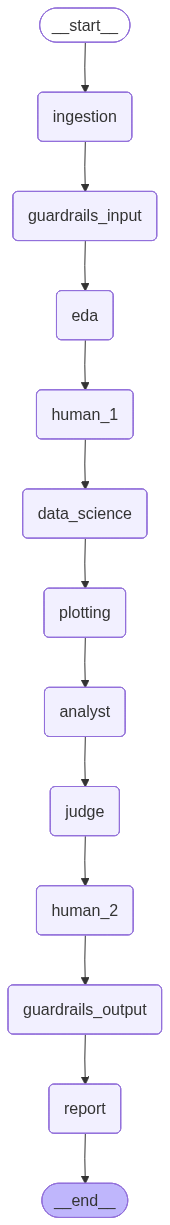

In [ ]:
import langgraph
from IPython.display import Image, display
import os
import uuid

# Ensure langgraph is installed
!pip install -q langgraph

!sudo apt-get install -y graphviz  # Only needed once if not already installed

model = init_gemini_model()          # or whatever model initialiser you use
graph = build_pipeline_graph(model)  # returns a StateGraph

# Compile the graph before visualizing
app = graph.compile()

# Render the Mermaid PNG and get its data
mermaid_png_data = app.get_graph().draw_mermaid_png()

# Save the PNG data to a persistent file and then display it
persistent_dir = "/content/mermaid_charts"
os.makedirs(persistent_dir, exist_ok=True)
image_filename = f"graph_{uuid.uuid4().hex}.png"
image_path = os.path.join(persistent_dir, image_filename)

with open(image_path, "wb") as f:
    f.write(mermaid_png_data)

display(Image(filename=image_path))

### Explanation of demo run

This cell demonstrates a full run of the data analysis pipeline, handling data loading from different sources:

1.  `import kagglehub`, `from google.colab import files`, `import os`, `from io import BytesIO`: Imports necessary modules for Kaggle data access, Colab file uploads, OS interactions, and byte stream handling.
2.  `user_goal = "Perform a comprehensive analysis of Netflix shows data to identify trends and patterns."`: Defines the user's overall objective for the analysis.
3.  `file_source_choice = 'kaggle'`: This variable determines how the input data is obtained. It's set to `'kaggle'` by default.
4.  **Data Source Logic**:
    *   If `file_source_choice == 'kaggle'`: It attempts to download the `creditcardfraud` dataset from Kaggle using `kagglehub.dataset_download`. It then reads `creditcard.csv` into a pandas DataFrame, converts it to bytes using `BytesIO`, and stores it in `final_data_for_pipeline`.
    *   If `file_source_choice == 'upload'`: (Not executed in this run due to `kaggle` choice) It would prompt the user to upload files using `files.upload()`.
    *   If `file_source_choice == 'dummy'` or if Kaggle/upload fails: It creates a simple dummy pandas DataFrame with `date`, `sales`, and `category` columns, converts it to bytes, and uses it as input.
    *   In this specific execution, the Kaggle dataset was successfully downloaded and processed. The logs show "Using Kaggle dataset: /kaggle/input/creditcardfraud/creditcard.csv".
5.  `final_state = run_pipeline(user_goal, final_data_for_pipeline)`: This is the core step where the entire LangGraph pipeline (defined in the previous cells) is executed. It passes the `user_goal` and the loaded `final_data_for_pipeline` to the `run_pipeline` function.
6.  **Output Printing**: After the pipeline completes, it prints key outputs from the `final_state`:
    *   The `final_state['judge_narrative']` (the refined analysis report from the LLM Judge).
    *   The `final_state['evaluation_notes']` (the judge's feedback on the initial analyst narrative).
    *   A list of generated plots (captions and file paths).
    *   The path to the generated Word report (`final_state['final_report_path']`).

The output shows the progress through each node of the pipeline, including summaries from EDA and Data Science, the draft analyst narrative, the judge's revised narrative and evaluation, and the details of the generated plots and report.

In [ ]:
import kagglehub
from google.colab import files
import os
from io import BytesIO

# User goal
user_goal = "Perform a comprehensive analysis of Netflix shows data to identify trends and patterns."

# --- Choose Data Source ---
# Set this to 'upload' to prompt for file upload, or 'kaggle' to use the default Kaggle dataset.
# You can also set it to 'dummy' for a simple generated dataset if no file is uploaded.
file_source_choice = 'kaggle' # @param ['upload', 'kaggle', 'dummy']

final_data_for_pipeline = {}

if file_source_choice == 'kaggle':
    # Use kagglehub to download the dataset
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    csv_file_name = 'creditcard.csv'
    full_kaggle_path = os.path.join(path, csv_file_name)

    if os.path.exists(full_kaggle_path):
        log(f"Using Kaggle dataset: {full_kaggle_path}", "INFO")
        df_kaggle = pd.read_csv(full_kaggle_path)
        kaggle_buf = BytesIO()
        df_kaggle.to_csv(kaggle_buf, index=False)
        kaggle_buf.seek(0)
        final_data_for_pipeline = {csv_file_name: kaggle_buf.getvalue()}
    else:
        log("Kaggle dataset not found. Falling back to dummy data.", "WARNING")
        file_source_choice = 'dummy' # Force dummy if Kaggle not found

if file_source_choice == 'upload':
    log("Please upload your files for analysis.", "INFO")
    uploaded_files = files.upload()
    if uploaded_files:
        final_data_for_pipeline = uploaded_files
    else:
        log("No files uploaded. Falling back to dummy data.", "WARNING")
        file_source_choice = 'dummy' # Force dummy if no files uploaded

if file_source_choice == 'dummy' or not final_data_for_pipeline:
    log("Using a dummy dataset for demo.", "INFO")
    demo_df = pd.DataFrame({
        "date": pd.date_range(start="2025-01-01", periods=100, freq="D"),
        "sales": np.random.randint(100, 1000, size=100),
        "category": np.random.choice(["A", "B", "C"], size=100)
    })
    demo_buf = BytesIO()
    demo_df.to_csv(demo_buf, index=False)
    demo_buf.seek(0)
    final_data_for_pipeline = {"demo.csv": demo_buf.getvalue()}

# Run the pipeline with the selected data source
final_state = run_pipeline(user_goal, final_data_for_pipeline)

# Print final outputs
print("\nFinal narrative:")
print(final_state['judge_narrative'][:1000])
print("\nEvaluation notes:")
print(final_state['evaluation_notes'])
print("\nPlots:")
if final_state['plots']:
    for p in final_state['plots']:
        print(f"- {p['caption']}: {p['path']}")
else:
    print("No plots generated.")
print("\nWord report saved to:", final_state['final_report_path'])

Using Colab cache for faster access to the 'creditcardfraud' dataset.
[2025-11-30 15:50:13] [INFO] Using Kaggle dataset: /kaggle/input/creditcardfraud/creditcard.csv
[2025-11-30 15:50:32] [INFO] Node: Ingestion started.
[2025-11-30 15:50:35] [INFO] Node: Guardrails input check.
[2025-11-30 15:50:35] [INFO] Node: EDA started.
EDA Summary:
DataFrame has 284807 rows and 31 columns.
Missing values summary: {'Time': 0, 'V1': 0, 'V2': 0, 'V3': 0, 'V4': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'V9': 0, 'V10': 0, 'V11': 0, 'V12': 0, 'V13': 0, 'V14': 0, 'V15': 0, 'V16': 0, 'V17': 0, 'V18': 0, 'V19': 0, 'V20': 0, 'V21': 0, 'V22': 0, 'V23': 0, 'V24': 0, 'V25': 0, 'V26': 0, 'V27': 0, 'V28': 0, 'Amount': 0, 'Class': 0}
Numeric columns summary available.
[2025-11-30 15:50:37] [INFO] Node: Human checkpoint after EDA.
[2025-11-30 15:56:21] [INFO] Node: Data Science analysis started.
Data Science Summary:
Strong correlations found: V2 vs Amount (r=0.53). Simple regression on Class (R²=0.52).
[2025-11-30 